# Ensembling Neural Networks in Parameter Space

## Ensembling in function space (DeepEnsembles)

In contrast to classical machine learning methods that are typically ensembled using methods such as bagging and boosting, neural networks are typically ensembled by averaging over the outputs of M models. These ensembles are referred to as "DeepEnsembles". We demonstrate this on the FMNIST dataset.

### MLP model training

We first train different fully-connected MLP (multi-layer-perceptron) models.

In [ ]:
#UNCOMMENT TO TRAIN MLP MODELS
"""
import os
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR

from models.mlp import MLP
from training.dataloaders import fmnist_train_loader
from training.trainer import Trainer

for model_index in range(3):
    #MLP with two layers, 10 outputs
    model = MLP([(28*28, 512),(512, 10)])
    
    optimizer = SGD(params=model.parameters(), lr=0.1, weight_decay=1e-5, momentum=0.9)

    trainer = Trainer(
            model=model,
            dataloader=fmnist_train_loader,
            optimizer=optimizer,
            lr_scheduler=CosineAnnealingLR,
            criterion=nn.CrossEntropyLoss(),
            num_epochs=20
    )
    trainer.train()

    torch.save(trainer.model.state_dict(), f'trained_models/mlp/mlp_{model_index}.pth')
"""

### MLP vs. DeepEnsemble Accuracy

We first evaluate the accuracy of each of the MLP models. We then compare this to a DeepEnsemble, in which we make a prediction by averaging over the outputs of the models. Hence the output of a DeepEnsemble composed of 3 MLP models (model_A, model_B, model_C) given an input is:

DeepEnsemble(input) = (model_A(input) + model_B(input) + model_C(input)) / 3

In [2]:
import os 

import matplotlib.pyplot as plt
import numpy as np
import torch

from evaluation.evaluator import Evaluator
from models.deep_ensemble import DeepEnsemble
from models.mlp import MLP
from training.dataloaders import fmnist_test_loader

models = []
names = []
for filename in os.listdir('trained_models/mlp'):
    model = MLP(in_out_units=[(28*28, 512),(512, 10)])
    model.load_state_dict(torch.load(os.path.join('trained_models/mlp', filename)))
    models.append(model)
    names.append(filename[0:-4])

for model_index, model in enumerate(models):
    evaluator = Evaluator(test_loader=fmnist_test_loader)
    accuracy = evaluator.evaluate(model)
    print(f'Accuracy model: {names[model_index]} is {accuracy}')

Accuracy model: mlp_0 is 87.97
Accuracy model: mlp_1 is 84.28
Accuracy model: mlp_2 is 87.3


In [3]:
deep_ensemble = DeepEnsemble(models)
evaluator = Evaluator(test_loader=fmnist_test_loader)
accuracy = evaluator.evaluate(deep_ensemble)

print(f'Accuracy DeepEnsemble is {accuracy}')

Accuracy DeepEnsemble is 88.54


We see that the DeepEnsemble has larger accuracy relative to the 3 MLP models.

## Drawbacks of DeepEnsembles

Although DeepEnsembles show coniderable accuracy increases and are more effective than classical ensembling methods such as bagging and boosting, they do suffer from considerable drawbacks. Namely that a DeepEnsemble requires storing M models and M forward passes at inference time (as we are averaging over the outputs of each model). Such large storage and computational costs are often prohibitive. For this reason other neural network methods have been developed to overcome the computational constraints. One of these methods is Knowledge Distillation

## Knowledge Distillation

Knowledge distillation is not limited to the context of ensembles, although ensembles are an ideal example of their application. The core idea behind knowledge distillation is to train a smaller student model on the soft labels of a larger teacher model, rather than on hard training labels. The central idea is that the output distribution of a teacher model is more informative than hard labels, as the output distribution includes information about inter-class similarities. In order to match the output distribution of the teacher model, the student is model is trained using a Kullback-Leibler Divergence loss, which is minimized if the two output distributions are equal. Although, the central idea of Knowledge Distillation is the idea of matching the soft labels of a teacher, usually a combination of soft-labels and hard-labels are used in the loss function. 

In terms of ensemble learning, a single MLP model (student) is trained to match the output distribution of a DeepEnsemble (teacher). The trained model is more accuracte relative to an MLP model trained only on hard labels and the computational drawbacks of DeepEnsembles are overcome.

## Training a knowledge distillation model

We train a MLP model with the following loss function:

LOSS = 0.5 * KD_LOSS + 0.5 * CE_LOSS

where KD_LOSS is Kullback-Leibler Divergence and CE_LOSS is CrossEntropy Loss. The teacher model in the KD_LOSS calculation is a DeepEnsemble of 3 MLP models.


In [ ]:
#UNCOMMENT TO TRAIN KNOWLEDGE DISTILLATION MODEL 
"""
import os
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR

from loss.knowledge_distillation_loss import KDLoss
from models.deep_ensemble import DeepEnsemble
from models.mlp import MLP
from training.dataloaders import fmnist_train_loader
from training.trainer import Trainer

#MLP with two layers, 10 outputs
model = MLP([(28*28, 512),(512, 10)])
    
optimizer = SGD(params=model.parameters(), lr=0.1, weight_decay=1e-5, momentum=0.9)

deep_ensemble = DeepEnsemble(models)
kd_loss = KDLoss(deep_ensemble=deep_ensemble, alpha=.5, temp=3)

trainer = Trainer(
    model=model,
    dataloader=fmnist_train_loader,
    optimizer=optimizer,
    lr_scheduler=CosineAnnealingLR,
    criterion=kd_loss,
    num_epochs=20
)
trainer.train()

torch.save(trainer.model.state_dict(), f'trained_models/kd/kd_0.pth')
"""


## Knowledge Distillation Accuracy



In [5]:
model = MLP(in_out_units=[(28*28, 512),(512, 10)])
model.load_state_dict(torch.load('trained_models/kd/kd_0.pth'))

evaluator = Evaluator(test_loader=fmnist_test_loader)
accuracy = evaluator.evaluate(model)
print(f'Accuracy Knowledge Distillation Model: is {accuracy}')

Accuracy Knowledge Distillation Model: is 88.81


For the given models, knowledge distillation outperforms the DeepEnsemble in terms of accuracy (88.81 vs. 88.54). Typically, a DeepEnsemble will outperform knowledge distillation in terms of accuracy, especially for larger ensemble sizes.

## Averaging in Parameter Space (PermAVG)

We propose a new neural network ensembling method in which we average in parameter space rather than in function space. In other words, instead of averaging over the outputs of M models, we average over the weights of each the M models, to create a single model. In this way we have overcome the need to store M models and M forward passes at inference time. In this way the method would be computationally equivalent to Knowledge Distillation. However, naively averaging over the weights of M models leads to near-random accuracy and therefore is not a promising method. Therefore, we propose to learn the optimal permutation of the weights, such that the average of the M models is optimal. 

## Naive Averaging

We first demonstrate the low accuracy of naively averaging over the weights of M models.

In [6]:
from models.perm_avg import PermAVG

naive_ensemble = PermAVG(models=models, naive=True)
evaluator = Evaluator(test_loader=fmnist_test_loader)
accuracy = evaluator.evaluate(naive_ensemble)

print(f'Accuracy Naive Weight Average is {accuracy}')

Accuracy Naive Weight Average is 76.06


We see that naively averaging over the weights lead to poor accuracy. The accuracy is lower than any of the individual MLP models. As the size of the ensemble grows the accuracy will continue to decrease until a near-random accuracy is reached.

## PermAVG

We now train a PermAVG model to learn the optimal permutations such that the average of the M models is optimal. Note that we are not actually learning permutation matrices as these are discrete and unsuited for gradient-based optimization but Doubly-Stochastic-Matrices (DSM), which is a continuous relaxation of permutation matrices.

In [ ]:
#UNCOMMENT TO TRAIN PERMAVG MODEL
"""
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from training.dataloaders import fmnist_train_loader
from training.trainer import Trainer

perm_avg = PermAVG(models=models, naive=False)

optimizer = Adam(params=list(perm_avg.param_matrices.values()), lr=0.1)

trainer = Trainer(
        model=perm_avg,
        dataloader=fmnist_train_loader,
        optimizer=optimizer,
        lr_scheduler=CosineAnnealingLR,
        criterion=nn.CrossEntropyLoss(),
        num_epochs=20
)
trainer.train()
torch.save(trainer.model, f'trained_models/perm_avg/perm_avg_0.pth')
"""

In [8]:
perm_avg = torch.load('trained_models/perm_avg/perm_avg_0.pth')
evaluator = Evaluator(test_loader=fmnist_test_loader)
accuracy = evaluator.evaluate(perm_avg)
print(f'Accuracy PermAVG: is {accuracy}')

Accuracy PermAVG: is 88.87


We find that the PermAVG method achieves 88.87% accuracy. This is better than knowledge distillation 88.81% and the DeepEnsemble 88.54%. Note however, that the PermAVG method is unable to scale with the number of models as both Knowledge Distillation and DeepEnsembles are. Additionally, it should be noted that one of the MLP models has low accuracy (84.28%), which could be a reason why the DeepEnsembles performs worse than the others. In general the accuracy performance of DeepEnsembles is superior to both methods, however due to the prohibitive computational constraints the other methods may be preferable. 

## Visualizing learned permutations

In order to understand what permutations the permAVG method is learning we visualize one of the permutation matrices. Again note that the permutation matrix is in fact a Doubly-Stochastic-Matrix, in which all columns and all rows sum to 1. In the case of a hard permutation matrix all rows and columns have one element value 1 and all other values 0.

Text(0.5, 1.0, 'Learned Permutation matrix for model 1, layer 0')

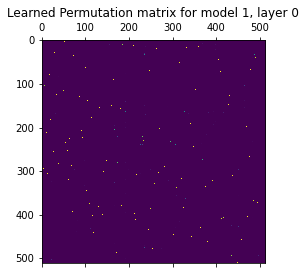

In [9]:
import matplotlib.pyplot as plt

perm_matrix = perm_avg.get_perm_matrix(1, 0)
perm_matrix = perm_matrix.detach().numpy()
plt.matshow(perm_matrix)
plt.title('Learned Permutation matrix for model 1, layer 0')
